# 19기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.


### Box-Jenkins 방법론
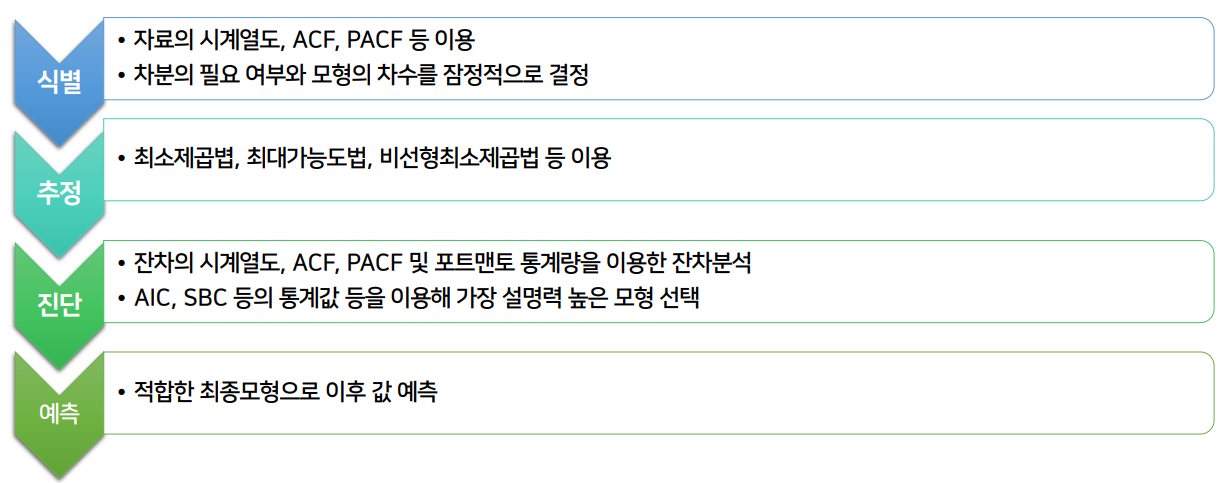

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [2]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.2/607.2 kB 5.6 MB/s eta 0:00:00a 0:00:01


In [14]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
import itertools

## 데이터 불러오기

In [4]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


2020년 1월 2일부터 2021년 4월 20일까지 삼성전자의 종가에 대한 시계열 자료이다.

## 1. 식별
- 주가 데이터 탐색
- 원자료 그래프와 ACF 그래프에서 모두 non-stationary한 개형을 보인다.
- 원자료의 경우, 평균과 분산이 일정하지 않다.
- ACF 그래프의 경우, 1에서 시작해 점점 감소하는 형태를 보인다. 
- 두 그래프를 통해 차분이 필요함을 확인하였으며, 모형의 차수를 잠정적으로 파악한다.


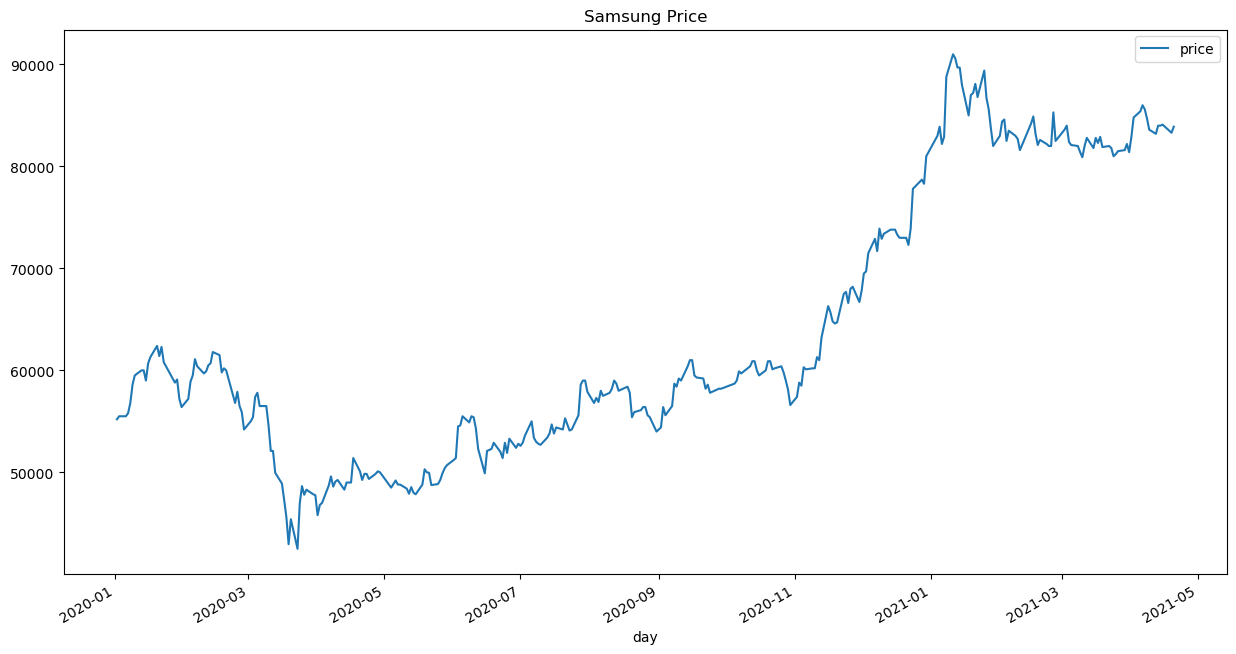

In [6]:
# Raw Data Plotting
fig, ax = plt.subplots(figsize=(15, 8))
samsung_df.plot(ax=ax)
plt.title("Samsung Price")
plt.show()
# non-stationary를 보인다. 로그 혹은 차분을 통해 보정이 필요하다.

In [7]:
# Train & Test data split
from sklearn.model_selection import train_test_split
samsung_df_train,samsung_df_test = train_test_split(samsung_df, test_size=0.1, shuffle=False) 
# 시계열자료이므로 셔플하지 않는다

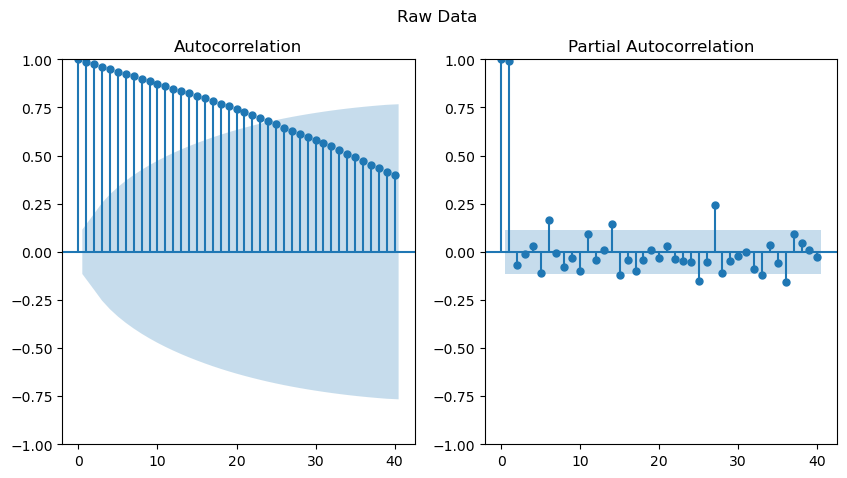

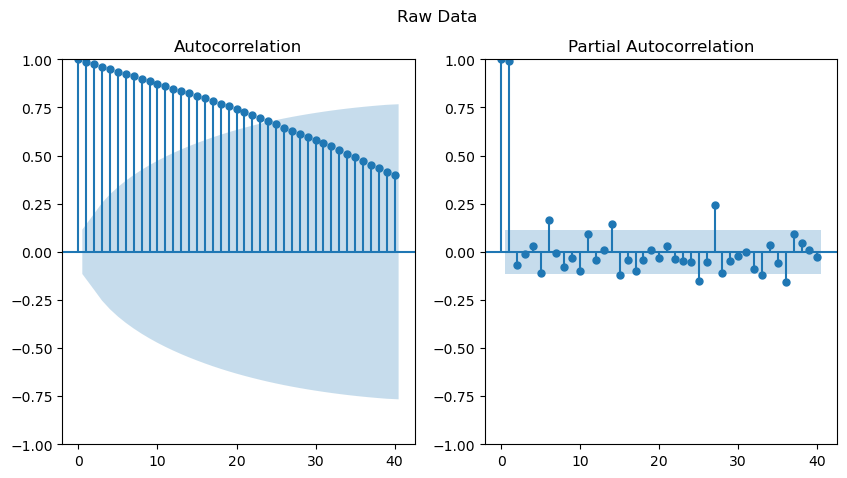

In [18]:
# ACF, PACF plotting
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(samsung_df_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(samsung_df_train.values.squeeze(), lags=40, ax=ax[1])
# ACF 그래프가 점점 감소하는 형태를 보이는데, 이는 raw dat가 non-stationary 할 때 전형적으로 나타난다. 


In [20]:
# 차분 데이터프레임 생성
diff_samsung_df_train = samsung_df_train.copy() # 원본을 보호하기 위해 차분 데이터는 원본을 copy하여 사용
diff_samsung_df_train = diff_samsung_df_train.diff() # difault 차분 수는 1이다
diff_samsung_df_train = diff_samsung_df_train.dropna() # 차분 후 첫번째 값과 마지막 값은 null값이 되므로 이를 drop하여 업데이트한다
print('Raw Data')
print(samsung_df_train)
print('Differenced Data')
print(diff_samsung_df_train)

Raw Data
              price
day                
2020-01-02  55200.0
2020-01-03  55500.0
2020-01-06  55500.0
2020-01-07  55800.0
2020-01-08  56800.0
...             ...
2021-02-25  85300.0
2021-02-26  82500.0
2021-03-02  83600.0
2021-03-03  84000.0
2021-03-04  82400.0

[289 rows x 1 columns]
Differenced Data
             price
day               
2020-01-03   300.0
2020-01-06     0.0
2020-01-07   300.0
2020-01-08  1000.0
2020-01-09  1800.0
...            ...
2021-02-25  3300.0
2021-02-26 -2800.0
2021-03-02  1100.0
2021-03-03   400.0
2021-03-04 -1600.0

[288 rows x 1 columns]


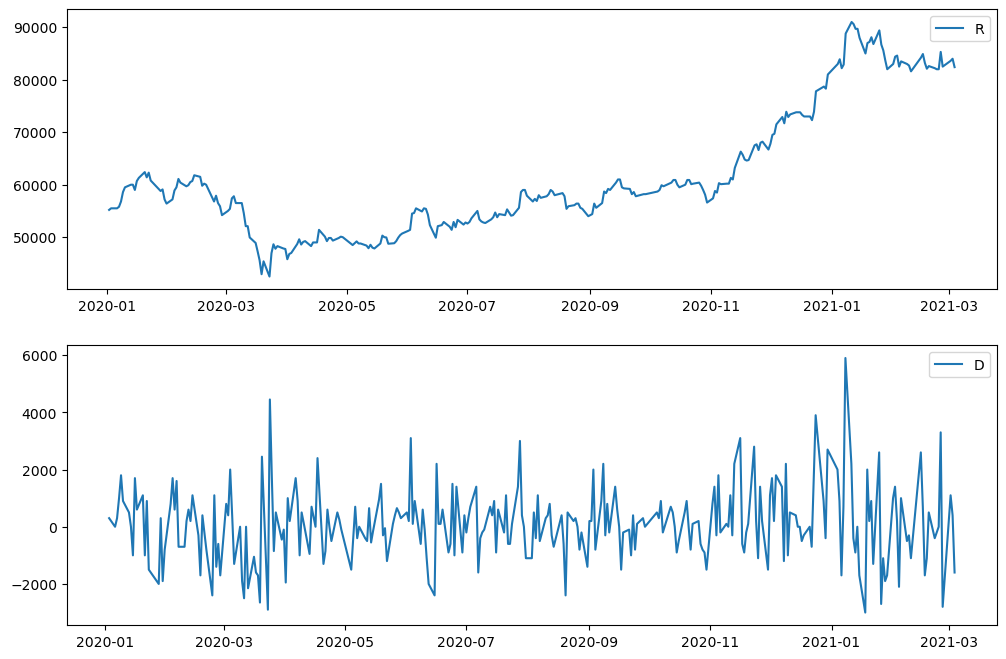

In [23]:
# RAW Data, Differenced Data plotting

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(samsung_df_train)
plt.legend('Raw Data')
plt.subplot(212)
plt.plot(diff_samsung_df_train)
plt.legend('Differenced Data')
plt.show()

# 1차 차분 이후 데이터가 stationary하게 변형되었음을 확인할 수 있다.

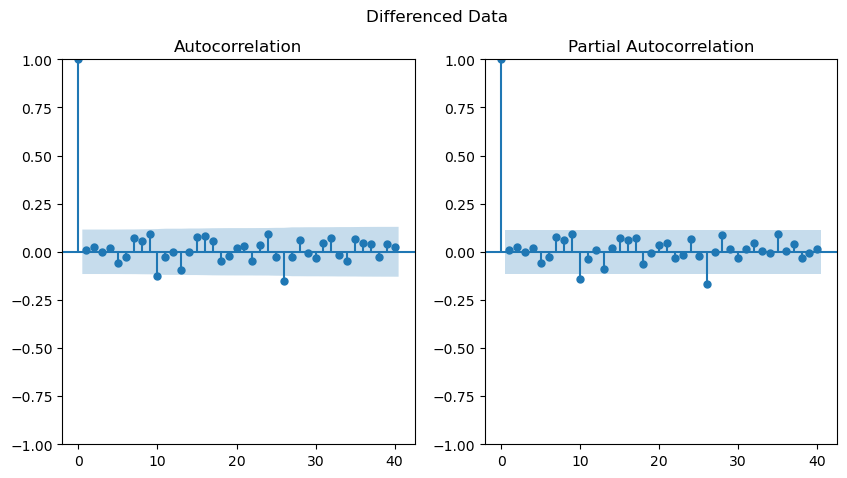

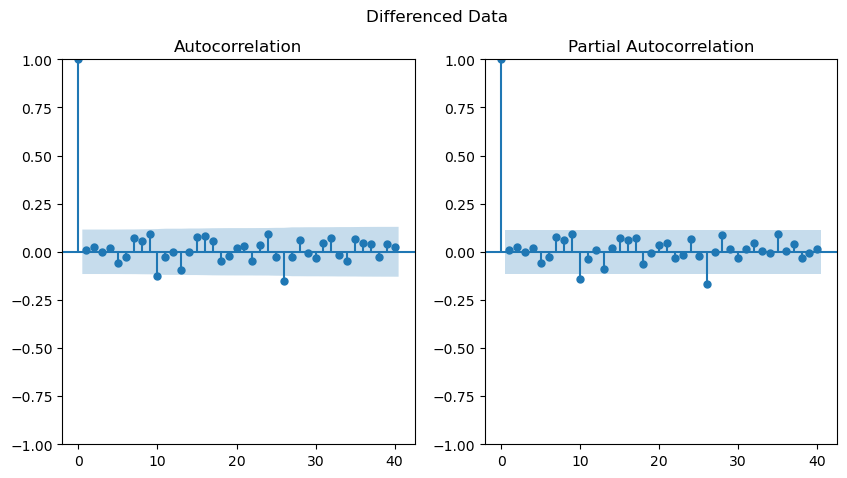

In [25]:
# 차분 데이터 ACF, PACF plotting
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_samsung_df_train.values.squeeze(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_samsung_df_train.values.squeeze(), lags=40, ax=ax[1])
# ACF 그래프가 점점 감소하는 형태였는데 1차 차분 후에는 안정화되었다. 
# 두 개형 모두 lag 27쯤 그래프가 구간 밖에 존재한다. 
# 따라서 ACF와 PACF 그래프의 개형만으로는 Model의 모수를 파악하기 어려움이 있다.


## 2. 추정
- 1차 차분이후 그래프가 stationary하게 변경되었으므로 d=1로 추정할 수 있다.
- 반면, p와 q의 경우, 앞서 ACF와 PACF그래프를 통해 모수를 추정하는 데 어려움이 있었다.
- p와 q가 [1,3] 구간에서 존재할 수 있는 모든 모수의 경우에 대한 진단을 다음 단계에서 진행하고, 모델의진단 결과가 가장 좋은 (AIC값이 가장 작은) 값으로 모수를 추정할 것이다.



## 3. 진단
- auto_arima package를 이용해서 모수의 구간별 AIC를 계산한다.
- AIC가 가장 작은 모델의 추정량을 사용하여 학습한다.

In [28]:
auto_arima_model = auto_arima(samsung_df_train, start_p=1, start_q=1, max_p = 3, max_q = 3, seasonal = False, d=1, trace=True, error_action='ignore',suppress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4935.053, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4937.025, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4939.058, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4941.054, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4937.005, Time=0.03 sec


/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4939.023, Time=0.09 sec


/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4940.887, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4942.969, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4938.983, Time=0.10 sec


/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4940.995, Time=0.23 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4942.610, Time=0.36 sec


/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4944.492, Time=0.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4940.978, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4942.984, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4944.555, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.403 seconds


/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


In [29]:
auto_arima_model.summary()
# AIC가 가장 작은 모델은 ARIMA(0,1,0)인 모델이다.
# (p,d,q) = (0,1,0)을 사용하여 train data를 학습한 결과는 다음과 같다.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  289
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2465.526
Date:                Tue, 14 Mar 2023   AIC                           4935.053
Time:                        10:41:43   BIC                           4942.379
Sample:                             0   HQIC                          4937.988
                                - 289                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     94.4444     77.431      1.220      0.223     -57.317     246.206
sigma2      1.597e+06   1.02e+05     15.623      0.000     1.4e+06     1.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                46.42
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.42   Skew:                             0.52
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 4. 예측
- 진단을 통해 구한 모수에 대한 추정량 (0,1,0)을 사용하여 학습한 모델을 통해 이후 시간에 따른 주가를 예측한다. 
- 예측값과 실제 test 데이터와의 차이를 확인하자. 

In [73]:
prediction = auto_arima_model.predict(len(samsung_df_test), return_conf_int=True)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(samsung_df_test.index)
predict_index[0]
# 2021-03-05부터 test data이다. 
# 2021-03-05부터 예측해보자.

/Users/oyujin/opt/anaconda3/envs/test/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Timestamp('2021-03-05 00:00:00')

In [54]:
prediction

(289    82494.444444
 290    82588.888889
 291    82683.333333
 292    82777.777778
 293    82872.222222
 294    82966.666667
 295    83061.111111
 296    83155.555556
 297    83250.000000
 298    83344.444444
 299    83438.888889
 300    83533.333333
 301    83627.777778
 302    83722.222222
 303    83816.666667
 304    83911.111111
 305    84005.555556
 306    84100.000000
 307    84194.444444
 308    84288.888889
 309    84383.333333
 310    84477.777778
 311    84572.222222
 312    84666.666667
 313    84761.111111
 314    84855.555556
 315    84950.000000
 316    85044.444444
 317    85138.888889
 318    85233.333333
 319    85327.777778
 320    85422.222222
 321    85516.666667
 dtype: float64,
 array([[80017.34701508, 84971.54187381],
        [79085.74410896, 86092.03366882],
        [78392.87473037, 86973.79193629],
        [77823.58291904, 87731.97263651],
        [77333.26398327, 88411.18046118],
        [76899.04192156, 89034.29141177],
        [76507.32733973, 89614.8948824

In [74]:
len(predicted_value)

33

In [75]:
len(samsung_df_test.index)

33

In [76]:
prediction_series = pd.Series(prediction,index=samsung_df_test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(samsung_df.price)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

ValueError: Length of values (2) does not match length of index (33)

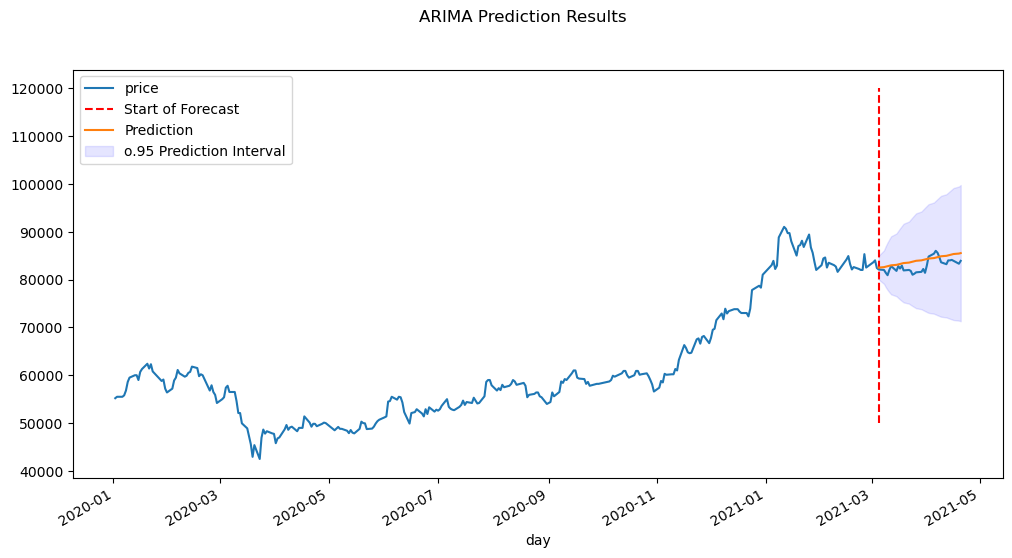

In [78]:
fig, ax = plt.subplots(figsize=(12,6))
samsung_df.plot(ax=ax)
ax.vlines('2021-03-05',50000,120000, linestyle='--', color='r', label = 'Start of Forecast');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index,predicted_lb,predicted_ub, color = 'b', alpha = 0.1, label ='o.95 Prediction Interval')
ax.legend(loc='upper left')
plt.suptitle('ARIMA Prediction Results')
plt.show()